In [1]:
# Remove any existing driver
!rm -rf /usr/bin/chromedriver
!apt-get install -y chromium-browser > /dev/null

# Download ChromeDriver v138 to match Chrome v138
!wget -q https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/138.0.7204.101/linux64/chromedriver-linux64.zip
!unzip -o chromedriver-linux64.zip
!mv chromedriver-linux64/chromedriver /usr/bin/chromedriver
!chmod +x /usr/bin/chromedriver

# Install selenium
!pip install selenium > /dev/null


Archive:  chromedriver-linux64.zip
  inflating: chromedriver-linux64/LICENSE.chromedriver  
  inflating: chromedriver-linux64/THIRD_PARTY_NOTICES.chromedriver  
  inflating: chromedriver-linux64/chromedriver  


In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import pandas as pd
import re
import time
import logging
from datetime import datetime

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class Cars24Scraper:
    def __init__(self, headless=False):
        """Initialize the scraper with Chrome options"""
        self.chrome_options = Options()
        if headless:
            self.chrome_options.add_argument("--headless")
        self.chrome_options.add_argument("--no-sandbox")
        self.chrome_options.add_argument("--disable-dev-shm-usage")
        self.chrome_options.add_argument("--disable-blink-features=AutomationControlled")
        self.chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
        self.chrome_options.add_experimental_option('useAutomationExtension', False)
        self.chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")

        self.driver = None
        self.wait = None

    def setup_driver(self):
        """Setup Chrome driver with options"""
        try:
            self.driver = webdriver.Chrome(options=self.chrome_options)
            self.driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")
            self.wait = WebDriverWait(self.driver, 10)
            logger.info("Chrome driver setup successful")
            return True
        except Exception as e:
            logger.error(f"Failed to setup Chrome driver: {e}")
            return False

    def scroll_to_load_all_content(self):
        """Handle infinite scrolling to load all car listings"""
        logger.info("Starting infinite scroll to load all content...")
        scroll_pause_time = 3
        max_scrolls = 50  # Prevent infinite scrolling
        scroll_count = 0

        last_height = self.driver.execute_script("return document.body.scrollHeight")

        while scroll_count < max_scrolls:
            # Scroll down to bottom
            self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

            # Wait for new content to load
            time.sleep(scroll_pause_time)

            # Calculate new scroll height
            new_height = self.driver.execute_script("return document.body.scrollHeight")

            if new_height == last_height:
                logger.info("Reached end of scrollable content")
                break

            last_height = new_height
            scroll_count += 1

            if scroll_count % 10 == 0:
                logger.info(f"Completed {scroll_count} scrolls...")

        logger.info(f"Scrolling completed after {scroll_count} scrolls")

    def extract_car_data(self, content_element):
        """Extract car data from a single car listing element"""
        try:
            raw_text = content_element.text
            lines = [line.strip() for line in raw_text.split('\n') if line.strip()]

            # Initialize data dictionary
            car_data = {
                'year': 'N/A',
                'model': 'N/A',
                'km_driven': 'N/A',
                'fuel_type': 'N/A',
                'transmission': 'N/A',
                'owners': 'N/A',
                'emi': 'N/A',
                'price': 'N/A',
                'location': 'N/A'
            }

            # Flags to track found data
            found_flags = {key: False for key in car_data.keys()}

            for i, line in enumerate(lines):
                if not line or line in ["+ other charges", "CARS24 Assured", "HIGH DEMAND"]:
                    continue

                # Extract year and model
                if re.match(r'^\d{4}\s+KIA', line, re.IGNORECASE) and not found_flags['year']:
                    match = re.match(r'(\d{4})\s+(.+)', line)
                    if match:
                        car_data['year'] = match.group(1)
                        car_data['model'] = match.group(2)
                        found_flags['year'] = True
                        found_flags['model'] = True
                    continue

                # Extract kilometers driven
                if 'km' in line.lower() and not found_flags['km_driven']:
                    if re.search(r'\d+.*km', line, re.IGNORECASE):
                        car_data['km_driven'] = line
                        found_flags['km_driven'] = True
                    continue

                # Extract fuel type
                fuel_types = ['Petrol', 'Diesel', 'Electric', 'CNG', 'Hybrid']
                if any(ft.lower() in line.lower() for ft in fuel_types) and not found_flags['fuel_type']:
                    car_data['fuel_type'] = line
                    found_flags['fuel_type'] = True
                    continue

                # Extract transmission
                transmission_keywords = ['Auto', 'Manual', 'Automatic', 'MT', 'AT', 'CVT']
                if any(trans.lower() in line.lower() for trans in transmission_keywords) and not found_flags['transmission']:
                    # Avoid false positives with fuel type combinations
                    if not any(ft.lower() in line.lower() for ft in fuel_types) or len(line.split()) == 1:
                        car_data['transmission'] = line
                        found_flags['transmission'] = True
                    continue

                # Extract number of owners
                if 'owner' in line.lower() and not found_flags['owners']:
                    car_data['owners'] = line
                    found_flags['owners'] = True
                    continue

                # Extract EMI
                if ('EMI' in line or 'emi' in line) and '₹' in line and not found_flags['emi']:
                    car_data['emi'] = line
                    found_flags['emi'] = True
                    continue

                # Extract price
                if line.startswith('₹') and ('lakh' in line.lower() or 'crore' in line.lower()) and not found_flags['price']:
                    car_data['price'] = line
                    found_flags['price'] = True
                    continue

                # Extract location
                if not found_flags['location']:
                    # Check if previous line contains "CARS24 Assured"
                    if i > 0 and 'CARS24 Assured' in lines[i - 1]:
                        car_data['location'] = line
                        found_flags['location'] = True
                        continue

                    # Check for known city names
                    cities = ['Mumbai', 'Thane', 'Navi Mumbai', 'Dombivli', 'Kandivali', 'Goregaon',
                             'Mulund', 'Pune', 'Bengaluru', 'Delhi', 'Chennai', 'Hyderabad',
                             'Ahmedabad', 'Kolkata', 'Surat', 'Jaipur', 'Lucknow', 'Kanpur', 'Nagpur']

                    if any(city.lower() in line.lower() for city in cities):
                        car_data['location'] = line
                        found_flags['location'] = True
                        continue

            return car_data

        except Exception as e:
            logger.error(f"Error extracting car data: {e}")
            return None

    def scrape_cars24(self, url, max_retries=3):
        """Main scraping function"""
        for attempt in range(max_retries):
            try:
                logger.info(f"Attempt {attempt + 1} to scrape Cars24...")

                if not self.setup_driver():
                    continue

                # Navigate to the URL
                logger.info(f"Navigating to: {url}")
                self.driver.get(url)

                # Wait for page to load
                time.sleep(5)

                # Handle infinite scrolling
                self.scroll_to_load_all_content()

                # Find all car listing elements
                logger.info("Extracting car listings...")
                try:
                    car_elements = self.wait.until(
                        EC.presence_of_all_elements_located((By.CLASS_NAME, 'styles_wrapper__b4UUV'))
                    )
                except TimeoutException:
                    logger.warning("Timeout waiting for car elements, trying alternative selector...")
                    car_elements = self.driver.find_elements(By.CSS_SELECTOR, '[class*="wrapper"]')

                if not car_elements:
                    logger.error("No car elements found!")
                    continue

                logger.info(f"Found {len(car_elements)} car listings")

                # Extract data from each car element
                cars_data = []
                for i, element in enumerate(car_elements):
                    car_data = self.extract_car_data(element)
                    if car_data:
                        cars_data.append(car_data)

                    if (i + 1) % 50 == 0:
                        logger.info(f"Processed {i + 1} car listings...")

                logger.info(f"Successfully extracted data for {len(cars_data)} cars")
                return cars_data

            except Exception as e:
                logger.error(f"Scraping attempt {attempt + 1} failed: {e}")
                if attempt == max_retries - 1:
                    logger.error("All scraping attempts failed")
                    return []
                time.sleep(5)  # Wait before retry

            finally:
                if self.driver:
                    self.driver.quit()
                    self.driver = None

        return []

    def save_to_csv(self, cars_data, filename='cars24_kia_enhanced.csv'):
        """Save extracted data to CSV file"""
        if not cars_data:
            logger.error("No data to save")
            return False

        try:
            df = pd.DataFrame(cars_data)

            # Rename columns for better readability
            df.columns = ['Year', 'Model', 'Km_driven', 'Fuel', 'Transmission',
                         'Owners', 'EMI', 'Price', 'Location']

            # Add timestamp
            df['scraped_at'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

            # Save to CSV
            df.to_csv(filename, index=False)
            logger.info(f"Data saved to {filename}")

            # Display sample data
            print(f"\n--- Scraped Data Sample (First 10 Rows) ---")
            print(df.head(10).to_string(index=False))
            print(f"\nTotal rows: {len(df)}")

            # Display data quality metrics
            print(f"\n--- Data Quality Metrics ---")
            for col in ['Year', 'Model', 'Km_driven', 'Fuel', 'Transmission', 'Price']:
                na_count = (df[col] == 'N/A').sum()
                print(f"{col}: {na_count} missing values ({na_count/len(df)*100:.1f}%)")

            return True

        except Exception as e:
            logger.error(f"Error saving to CSV: {e}")
            return False

def main():
    """Main function to run the scraper"""
    url = "https://www.cars24.com/buy-used-cars-mumbai/?f=make%3A%3D%3Akia%3Bmodel%3Ain%3Asonet%2Cseltos&sort=bestmatch&serveWarrantyCount=true&listingSource=TabFilter&storeCityId=2378"

    scraper = Cars24Scraper(headless=False)  # Set to True for headless mode

    logger.info("Starting Cars24 KIA scraper...")
    cars_data = scraper.scrape_cars24(url)

    if cars_data:
        scraper.save_to_csv(cars_data)
        logger.info("Scraping completed successfully!")
    else:
        logger.error("Scraping failed - no data extracted")

if __name__ == "__main__":
    main()

Starting data extraction from Cars24...
URL: https://www.cars24.com/buy-used-kia-cars-mumbai/?sort=bestmatch&serveWarrantyCount=true&listingSource=TabFilter&storeCityId=2378
Data saved to kia_cars_mumbai.csv
Total cars extracted: 14

First 5 rows of data:
   Kilometers Driven  Year of Manufacture Fuel Type Transmission       Price  \
0              26550                 2020    Petrol         Auto  12.90 lakh   
1              91900                 2018    Diesel         Auto  13.56 lakh   
2              25980                 2020    Petrol       Manual   9.55 lakh   
3              16410                 2021    Diesel       Manual  12.05 lakh   
4              60660                 2019    Petrol         Auto  10.28 lakh   

                         Location Number of owners  
0               Kandivali  Mumbai        2nd owner  
1  Regency Anantam  Dombivli East        2nd owner  
2                Goregaon  Mumbai        1st owner  
3             Mulund West  Mumbai        1st owner 

In [24]:
 df = pd.read_csv('/content/kia_cars_mumbai_manual.csv')
 df

,Kilometers Driven,Year of Manufacture,Fuel Type,Transmission,Price,Location,Number of owners
0,26550,2020,Petrol,Auto,12.90 lakh,Kandivali Mumbai,2nd owner
1,91900,2018,Diesel,Auto,13.56 lakh,Regency Anantam Dombivli East,2nd owner
2,25980,2020,Petrol,Manual,9.55 lakh,Goregaon Mumbai,1st owner
3,16410,2021,Diesel,Manual,12.05 lakh,Mulund West Mumbai,1st owner
4,60660,2019,Petrol,Auto,10.28 lakh,Regency Anantam Dombivli East,1st owner
5,16900,2021,Petrol,Auto,10.50 lakh,Goregaon Mumbai,1st owner
6,65730,2019,Diesel,Auto,12.10 lakh,Mulund West Mumbai,1st owner
7,49740,2019,Diesel,Manual,11.84 lakh,Goregaon Mumbai,1st owner
8,31480,2020,Petrol,Auto,15.50 lakh,Regency Anantam Dombivli East,1st owner
9,18590,2021,Petrol,Manual,11.65 lakh,Seawood,1st owner


/tmp/ipython-input-8-1835070734.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Kilometers Driven', y='Number of owners', inner='stick', palette='Dark2')


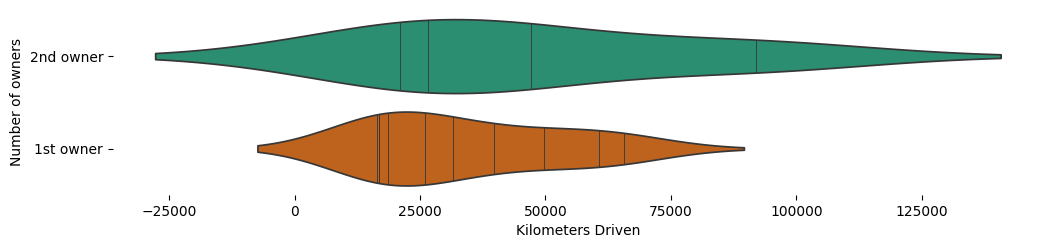

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Number of owners'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Kilometers Driven', y='Number of owners', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)



Based on the violin plot showing 'Kilometers Driven' versus 'Number of owners', we can make the following conclusions:

- **1st owner cars tend to have lower kilometers driven** compared to 2nd owner cars. The bulk of the data for 1st owner cars is concentrated towards the lower end of the 'Kilometers Driven' axis, with a wider spread extending to higher values, but the density is highest at lower kilometers.
- **2nd owner cars show a wider distribution of kilometers driven**, and while there are cars with low kilometers, there is a significant presence of cars with higher kilometers compared to 1st owner vehicles.
- **The median kilometers driven appears to be lower for 1st owner cars** than for 2nd owner cars.
- The plot suggests a general trend: cars that have had only one owner are likely to have accumulated fewer kilometers than cars that have had two owners. This aligns with common expectations as cars typically accumulate mileage over time, and changing ownership can happen later in a car's life.

/tmp/ipython-input-9-463900857.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Kilometers Driven', y='Location', inner='stick', palette='Dark2')


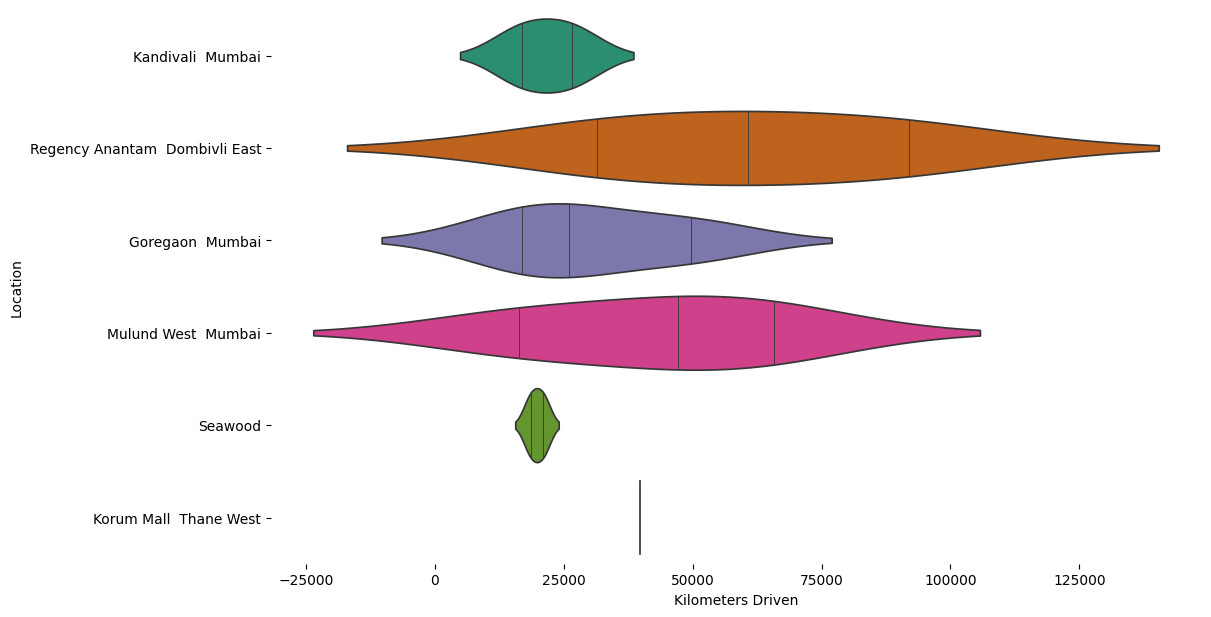

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Location'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Kilometers Driven', y='Location', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Based on the violin plot showing 'Kilometers Driven' versus 'Location', we can observe the following:

- **Regency Anantam, Dombivli East** and **Mulund West, Mumbai** locations appear to have cars with generally higher kilometer readings compared to other locations. The violin shapes for these locations are wider towards higher kilometer values and the density seems more spread out across the higher range.
- **Goregaon, Mumbai** and **Kandivali, Mumbai** locations show a mix of kilometer readings, with significant presence of cars in the lower to mid-range kilometers. Goregaon in particular seems to have a concentration of cars with lower kilometers.
- **Seawood** and **Korum Mall, Thane West** locations seem to have cars predominantly with lower kilometer readings. The violin shapes are narrower and more concentrated towards the lower end of the 'Kilometers Driven' axis.
- There is variability in the distribution of kilometers driven across different locations, suggesting that the typical usage or availability of cars with certain mileage can differ based on the location.

/tmp/ipython-input-10-2724847726.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Kilometers Driven', y='Transmission', inner='stick', palette='Dark2')


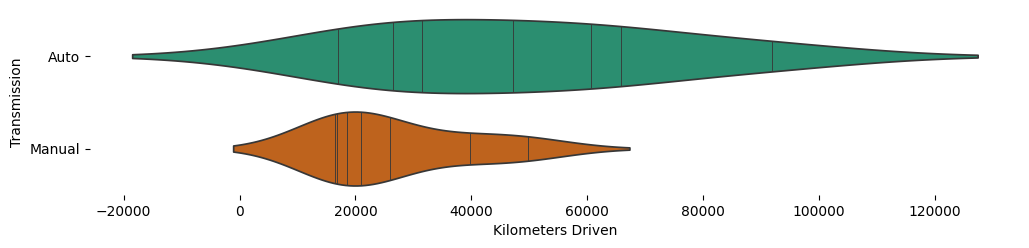

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Transmission'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Kilometers Driven', y='Transmission', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


Based on the violin plot showing 'Kilometers Driven' versus 'Transmission', we can make the following conclusions:

- **Automatic transmission cars show a wider distribution of kilometers driven** compared to manual transmission cars. While there are automatic cars with low kilometers, the distribution extends to significantly higher kilometer values.
- **Manual transmission cars appear to be more concentrated in the lower to mid-range of kilometers driven.** The density of manual cars is higher at lower mileage points compared to automatic cars.
- The plot suggests that **automatic transmission cars, on average, might have accumulated more kilometers** than manual transmission cars in this dataset.
- There are manual transmission cars with higher kilometers, but the distribution is not as spread out towards the higher end as it is for automatic transmission cars.

/tmp/ipython-input-11-1157444222.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Kilometers Driven', y='Fuel Type', inner='stick', palette='Dark2')


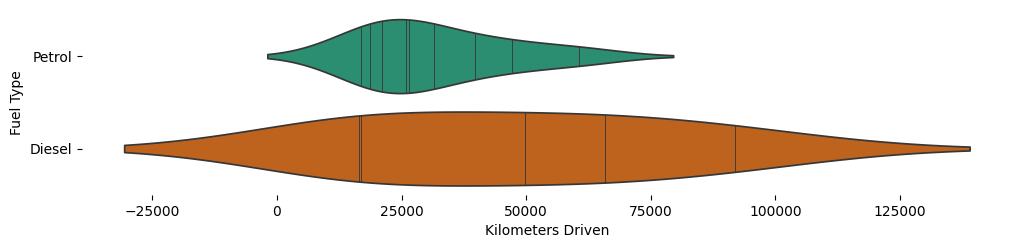

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Fuel Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Kilometers Driven', y='Fuel Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


Based on the violin plot showing 'Kilometers Driven' versus 'Fuel Type', we can observe the following:

- **Diesel cars tend to have higher kilometers driven** compared to petrol cars. The violin shape for Diesel cars is wider and extends to significantly higher kilometer values.
- **Petrol cars are more concentrated in the lower to mid-range of kilometers driven.** The density of petrol cars is higher at lower mileage points compared to diesel cars.
- The plot suggests that **diesel vehicles, on average, are driven more over their lifetime** than petrol vehicles in this dataset. This aligns with the common understanding that diesel engines are often preferred for longer distance driving due to better fuel efficiency.

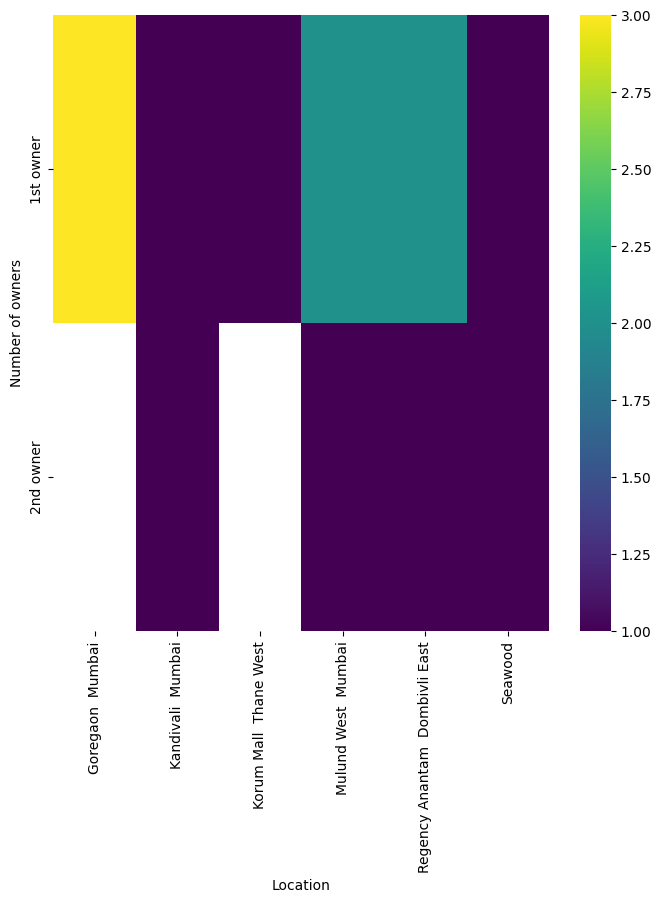

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Number of owners'].value_counts()
    for x_label, grp in df.groupby('Location')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Location')
_ = plt.ylabel('Number of owners')

Based on the heatmap showing the distribution of 'Number of owners' across different 'Locations', we can make the following conclusions:

- **Goregaon, Mumbai**, **Mulund West, Mumbai**, and **Regency Anantam, Dombivli East** have a higher count of cars with the "1st owner" compared to other locations in this dataset. This is indicated by the brighter colors in the heatmap for these locations under the '1st owner' category.
- **Kandivali, Mumbai** shows a notable presence of both "1st owner" and "2nd owner" cars, with a relatively balanced distribution compared to some other locations.
- **Seawood** and **Korum Mall, Thane West** appear to have a smaller number of total listings in this dataset, but the listings present are primarily "1st owner" vehicles.
- There is a varying distribution of owner types across different locations, which could be influenced by factors such as the volume of car sales, the preferences of buyers and sellers in those areas, or the turnover rate of vehicles.

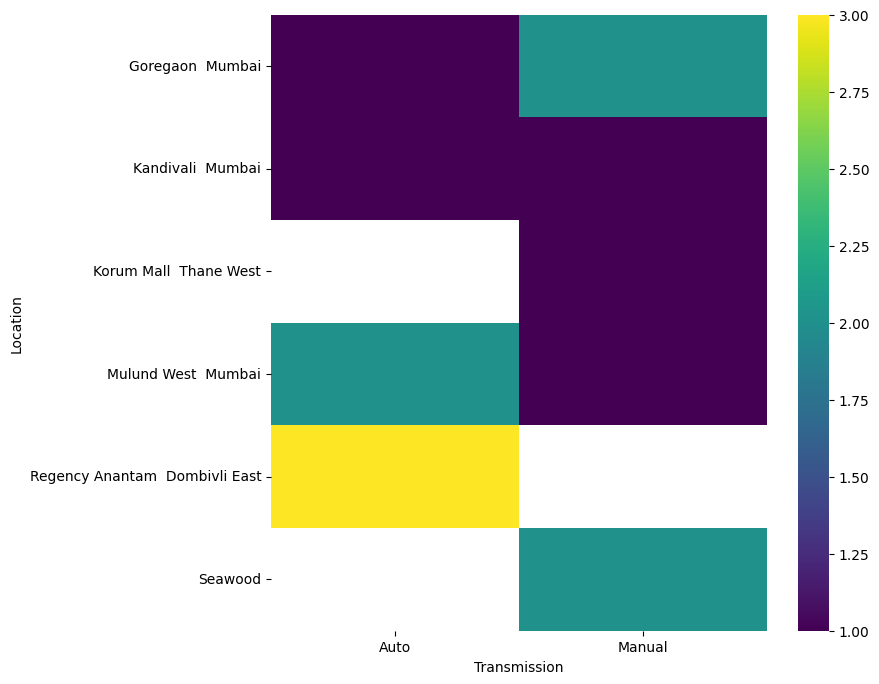

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Location'].value_counts()
    for x_label, grp in df.groupby('Transmission')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Transmission')
_ = plt.ylabel('Location')


Based on the heatmap showing the distribution of 'Location' across different 'Transmission' types, we can make the following conclusions:

- **Goregaon, Mumbai**, **Mulund West, Mumbai**, and **Regency Anantam, Dombivli East** have a significant number of both Automatic and Manual transmission cars listed. These locations show brighter areas in the heatmap for both transmission types.
- **Kandivali, Mumbai** also shows a good distribution of both Automatic and Manual cars.
- **Seawood** and **Korum Mall, Thane West** appear to have a smaller number of listings in this dataset, but the listings present are predominantly Manual transmission cars.
- The distribution of transmission types varies across locations, with some locations showing a more even split between automatic and manual, while others have a stronger leaning towards one type, which could reflect local market preferences or availability.

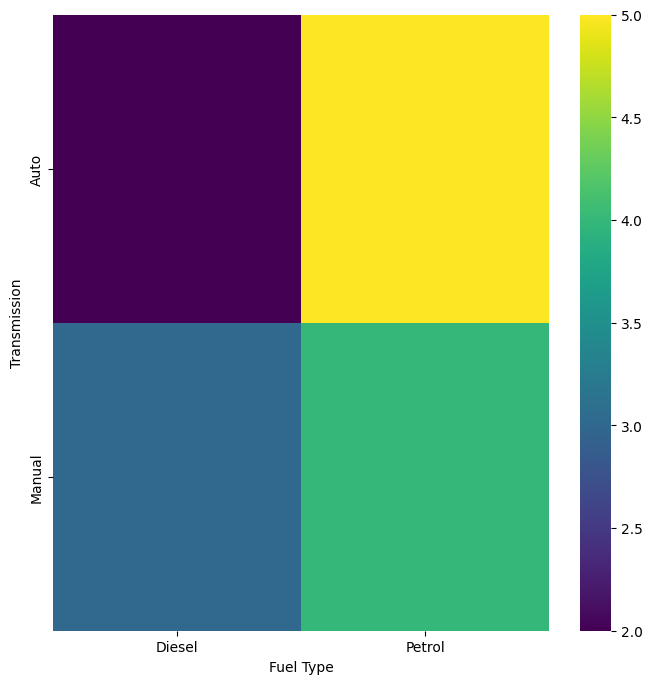

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Transmission'].value_counts()
    for x_label, grp in df.groupby('Fuel Type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Fuel Type')
_ = plt.ylabel('Transmission')

Based on the heatmap showing the distribution of 'Transmission' types across different 'Fuel Types', we can make the following conclusions:

- **Petrol fuel type has a notable presence of both Automatic and Manual transmission cars.** The heatmap indicates a relatively balanced distribution of transmission types for petrol vehicles in this dataset.
- **Diesel fuel type also shows both Automatic and Manual transmission cars, but the density for Automatic transmission might be slightly higher** compared to Manual transmission for diesel vehicles in this specific dataset, as suggested by the slightly brighter shade for 'Automatic' under 'Diesel'.
- The plot suggests that both petrol and diesel cars are available in both automatic and manual transmission variants, but the proportion of automatic versus manual might differ between the two fuel types.

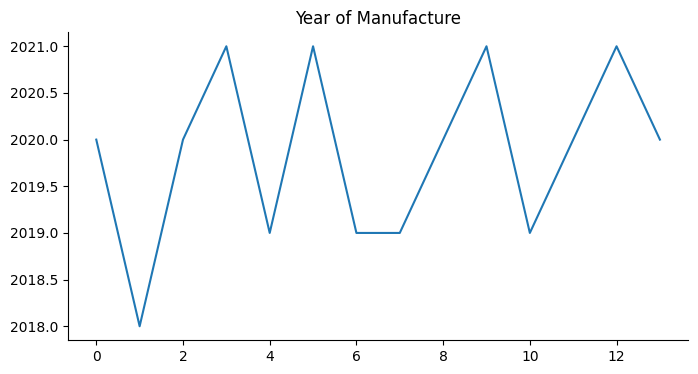

In [15]:
from matplotlib import pyplot as plt
df['Year of Manufacture'].plot(kind='line', figsize=(8, 4), title='Year of Manufacture')
plt.gca().spines[['top', 'right']].set_visible(False)


Based on the line plot showing the 'Year of Manufacture' distribution:

- The plot shows a relatively flat line across the years 2018 to 2021.
- This indicates that the dataset contains cars across these four years, with a relatively even distribution or frequency of cars from each of these manufacturing years.
- There isn't a strong trend of a sharp increase or decrease in the number of cars from a particular year within this range in the extracted data.

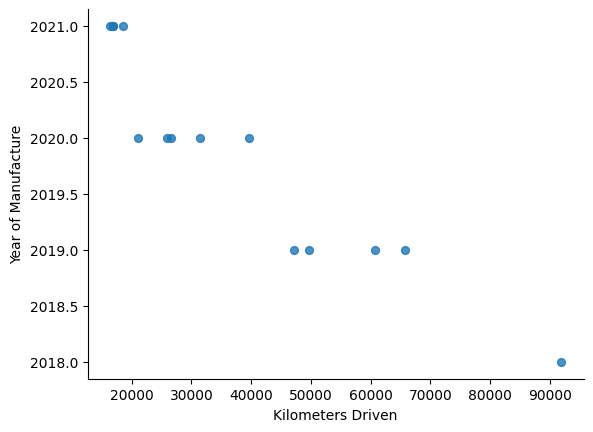

In [17]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Kilometers Driven', y='Year of Manufacture', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)


Based on the scatter plot showing 'Kilometers Driven' versus 'Year of Manufacture', we can make the following conclusions:

- There is a clear inverse relationship between 'Kilometers Driven' and 'Year of Manufacture'. **Newer cars (higher 'Year of Manufacture') tend to have fewer kilometers driven** compared to older cars.
- Cars manufactured in **2021** generally have the lowest kilometers driven.
- As the 'Year of Manufacture' decreases (gets older), the range and upper limit of 'Kilometers Driven' tend to increase. Cars from **2018** and **2019** show the highest kilometer readings.
- The plot confirms the expected trend that vehicles accumulate mileage over time, so older cars are more likely to have been driven longer distances.

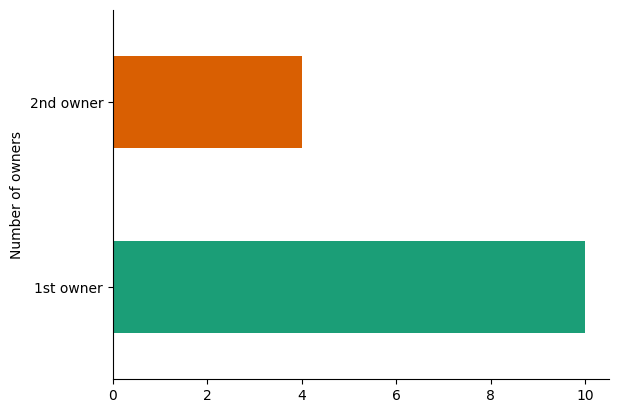

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Number of owners').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

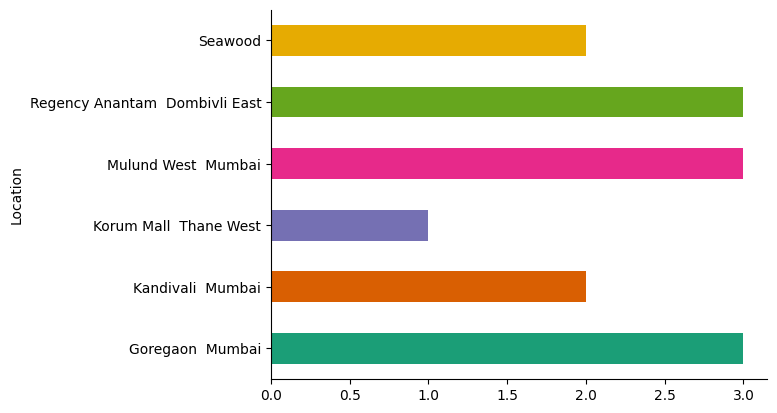

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Location').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

ased on the horizontal bar plots:

- **Number of owners:** The plot shows that the dataset contains more cars with "1st owner" compared to "2nd owner". This indicates that a majority of the listed used cars in this dataset are still with their original owners.
- **Location:** The plot displays the count of cars listed from different locations. "Goregaon, Mumbai", "Mulund West, Mumbai", and "Regency Anantam, Dombivli East" appear to have the highest number of car listings in this dataset. "Kandivali, Mumbai" also has a significant number of listings. "Seawood" and "Korum Mall, Thane West" have fewer listings compared to the other locations.

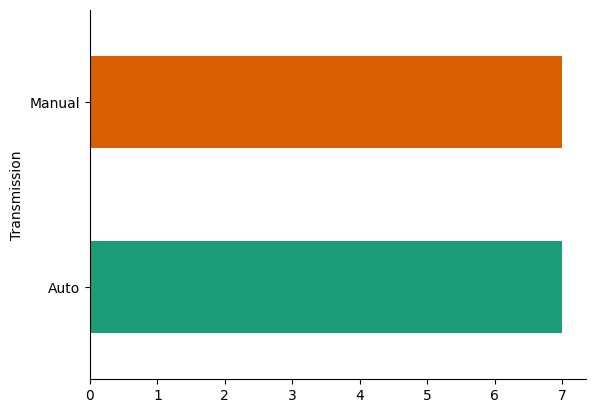

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Transmission').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Based on the horizontal bar plot showing the distribution of 'Transmission' types:

- The plot clearly indicates that there are more **Manual transmission** cars in the dataset compared to **Automatic transmission** cars.
- This suggests that, among the listed Kia cars in this dataset from the specified locations, Manual transmission vehicles are more prevalent than Automatic transmission vehicles.

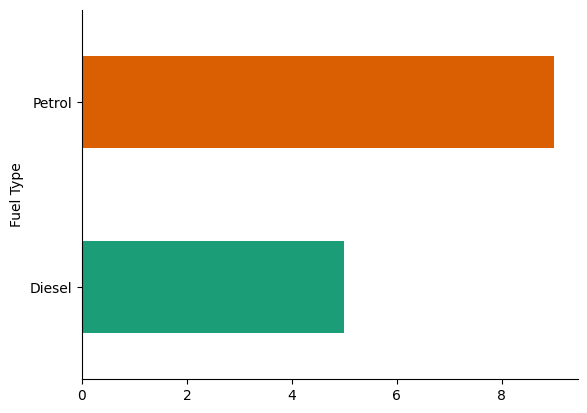

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Fuel Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


Based on the horizontal bar plot showing the distribution of 'Fuel Type':

- The plot shows that there are more **Petrol** cars in the dataset compared to **Diesel** cars.
- This indicates that, among the listed Kia cars in this dataset from the specified locations, Petrol vehicles are more frequently listed than Diesel vehicles.

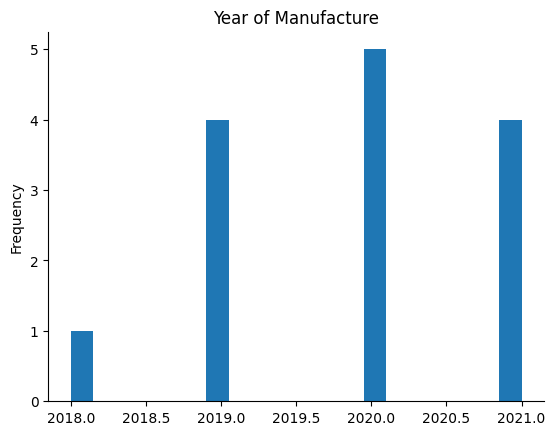

In [22]:
from matplotlib import pyplot as plt
df['Year of Manufacture'].plot(kind='hist', bins=20, title='Year of Manufacture')
plt.gca().spines[['top', 'right',]].set_visible(False)

Based on the histogram of 'Year of Manufacture':

- The histogram shows the frequency distribution of cars based on their manufacturing year.
- The bins represent ranges of years, and the height of each bar indicates how many cars fall into that year range.
- Without specific bin labels or a clearer representation of individual years, it's challenging to give a precise conclusion about the exact number of cars from each year. However, the shape of the histogram would reveal if there's a higher concentration of cars from certain years within the 2018-2021 range. For instance, if there's a peak, it suggests a larger number of cars were manufactured in or around that year.

To get a more precise conclusion, examining the actual counts per year (as seen in the line plot or a value_counts() of the 'Year of Manufacture' column) would be more informative than this specific histogram plot in its current form without clearer binning.

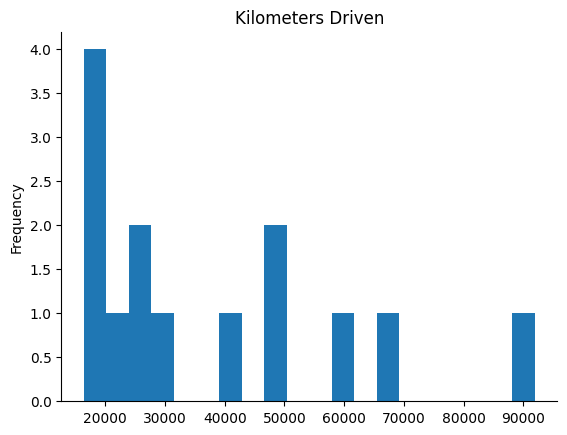

In [23]:
from matplotlib import pyplot as plt
df['Kilometers Driven'].plot(kind='hist', bins=20, title='Kilometers Driven')
plt.gca().spines[['top', 'right',]].set_visible(False)

Based on the histogram of 'Kilometers Driven':

- The histogram shows the frequency distribution of cars based on the distance they have been driven.
- The plot indicates that there is a higher concentration of cars in the lower kilometer ranges. The bars are generally taller towards the left side of the histogram, which represents fewer kilometers driven.
- As the kilometers driven increase, the frequency of cars decreases, meaning fewer cars in this dataset have very high kilometer readings.
- The distribution appears to be skewed towards the lower end, suggesting that a significant portion of the listed cars have relatively low mileage.
- The bins represent ranges of kilometers, and the height of each bar indicates how many cars fall into that kilometer range.